# Monk2
Grid Search for Monk2 dataset model selection


In [242]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.components.Validation.KFoldCrossValidation import validate
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk2
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk2 dataset 

In [243]:
training_data, training_labels, test_data, test_labels = read_monk2("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [244]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [245]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [246]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()][1]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 100
epochs = 500

final_file = "monk2_models_configs_hist3.json"

if not os.path.exists(final_file):
    dir_path = "Monk2/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = [1]
    num_of_units = set([unit1 if unit1!=1 else 2 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = all_json_data['initializers'].value_counts().index.tolist()
    activations = ['sigmoid', 'tanh']
    
    # ea = EarlyStoppingCallback(patiente_limit=50, eps=)
    # 
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=100, workers=-2, number_of_initializations=2, return_models_history=True,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_file)
else: 
    with open(final_file, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [247]:
# my_configs = []
# for config in configs[1]:
#     config['callbacks'] = ['earlystopping_1e-4_20_False']
# ea = EarlyStoppingCallback(restore_weights=True)
config = {'regularization': 1e-07, 'learning_rate': 0.7, 'loss_function': 'mse', 'activation_functions': ['tanh'], 'output_activation': 'sigmoid', 'num_of_units': [4], 'num_layers': 1, 'momentum': 0.9, 'optimizer': 'sgd', 'initializers': 'uniform', 'nesterov': True, 'input_shape': [169, 17], 'callbacks': ['earlystopping_1e-4_20_False'], 'verbose': False, 'outputs': 1, 'model_name': 'Model221'}
configs[1] = [config for _ in range(10)]
# if __name__ == '__main__':
#     # for config in configs[1]:
#     #     config['callbacks'] = [ea]
#     my_configs.append(
#         validate(configs[1], x=training_data, y_true=training_labels, epochs=epochs, return_models_history=True,
#                           batch_size=batch_size, max_configs=100, number_of_initializations=1, n_splits=4, parallel=False
#                           ))
#     
#     # my_configs.append(
#     #     hold_out(configs[1], training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
#     #                       batch_size=batch_size, num_models=100, number_of_initializations=2,
#     #                       ))
# 
# configs=my_configs[0]

In [248]:
models = []
old_histories = configs[0]
my_configs=configs[1]
with tqdm(total=len(my_configs)) as pbar:
    for old_hist, config in zip(old_histories, my_configs):
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, val=test_data, val_labels=test_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, old_hist['binary_accuracy'][-1],  old_hist['val_binary_accuracy'][-1], model.history['mse'],  model.history['val_mse'], model.history['mse'], model.history['binary_accuracy'], model.history['val_binary_accuracy'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'Old_Accuracy', 'Old_Accuracy_val', 'Old_History', 'Old_History_val', 'History', 'Accuracy_History', 'Val_Accuracy_History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 10/10 [00:00<00:00, 10.28it/s]


In [249]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'History_Std', 'Score', 'Test_Score'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Old_Accuracy_val'] >= 1]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.09]
# df_sorted = df_sorted[df_sorted['Test_Score'] <= 0.0003]
df_sorted = df_sorted[df_sorted['Score'] <= 0.0003]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
old_histories = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History']].values}
old_histories_val = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History_val']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,Old_Accuracy,Old_Accuracy_val,Old_History,Old_History_val,History,Accuracy_History,Val_Accuracy_History,Model,Config,Num_Layers,Num_of_Units,Name
4,0.000262,0.052749,1.0,0.000681,1.0,249,1.0,1.0,"[0.23769014, 0.23505576, 0.23199598, 0.2295790...","[0.23221663, 0.2284388, 0.22360441, 0.22097445...","[0.23769014, 0.23505576, 0.23199598, 0.2295790...","[0.6094674556213018, 0.6272189349112426, 0.621...","[0.6550925925925926, 0.6759259259259259, 0.671...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.7...",1,[4],Model221
7,0.000288,0.075272,1.0,0.000478,1.0,185,1.0,1.0,"[0.25469804, 0.24059997, 0.23462838, 0.2335348...","[0.25695157, 0.23644795, 0.22428967, 0.2216460...","[0.25469804, 0.24059997, 0.23462838, 0.2335348...","[0.47928994082840237, 0.5976331360946746, 0.62...","[0.48148148148148145, 0.6203703703703703, 0.66...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.7...",1,[4],Model221


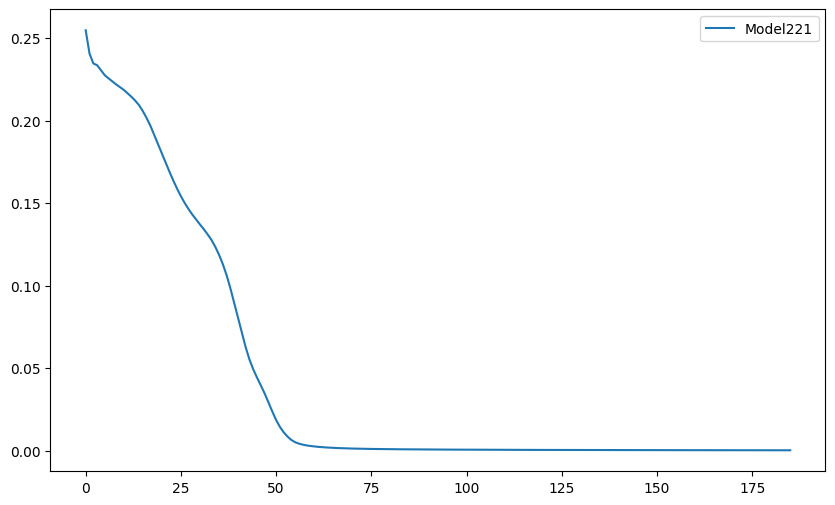

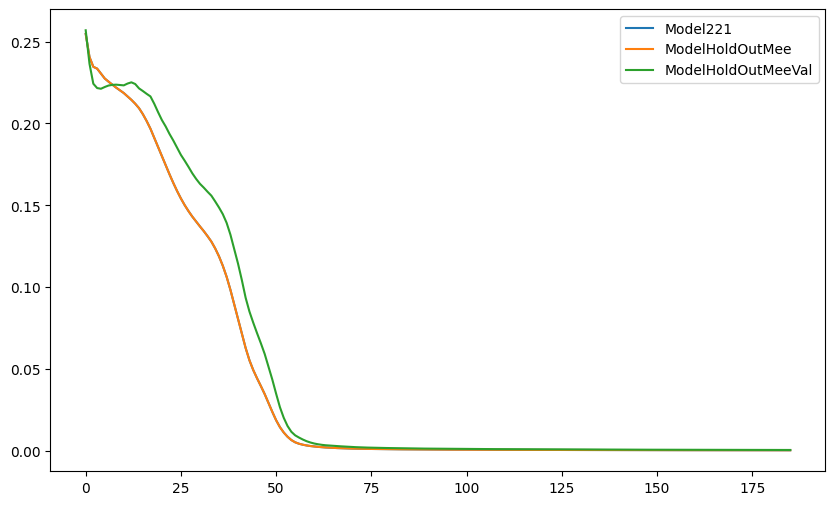

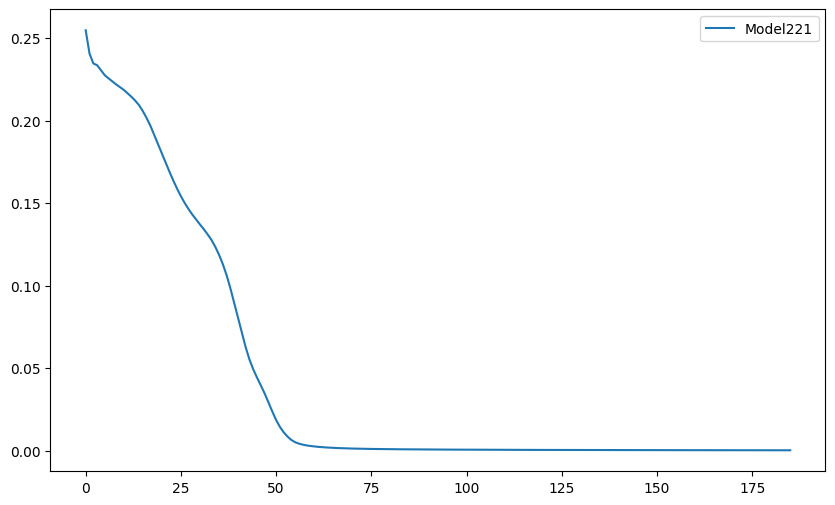

In [250]:
plot_history(histories)
# plot_history({'Model3699': histories['Model3699'], 'Model3699_old': old_histories['Model3699'], 'Model3699_Val': old_histories_val['Model3699']})
plot_history({list(histories)[0]: list(histories.values())[0], 'ModelHoldOutMee': list(old_histories.values())[0], 'ModelHoldOutMeeVal': list(old_histories_val.values())[0]})
plot_history({list(histories)[0]: list(histories.values())[0]})


In [251]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array1 = np.array(row['History'])
        # differences1 =  (np.diff(array1) - np.mean(array1)) /np.mean(array1)
        differences1 =  (np.diff(array1) / np.mean(array1))
        min_consecutive_difference = np.min(differences1)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
result_row.to_csv('Monk2_train.csv')

Selected row:
Score                                                            0.000262
History_Std                                                      0.052749
Accuracy                                                              1.0
Test_Score                                                       0.000681
Test_Accuracy                                                         1.0
Trained_Epochs                                                        249
Old_Accuracy                                                          1.0
Old_Accuracy_val                                                      1.0
Old_History             [0.23769014, 0.23505576, 0.23199598, 0.2295790...
Old_History_val         [0.23221663, 0.2284388, 0.22360441, 0.22097445...
History                 [0.23769014, 0.23505576, 0.23199598, 0.2295790...
Accuracy_History        [0.6094674556213018, 0.6272189349112426, 0.621...
Val_Accuracy_History    [0.6550925925925926, 0.6759259259259259, 0.671...
Model                   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


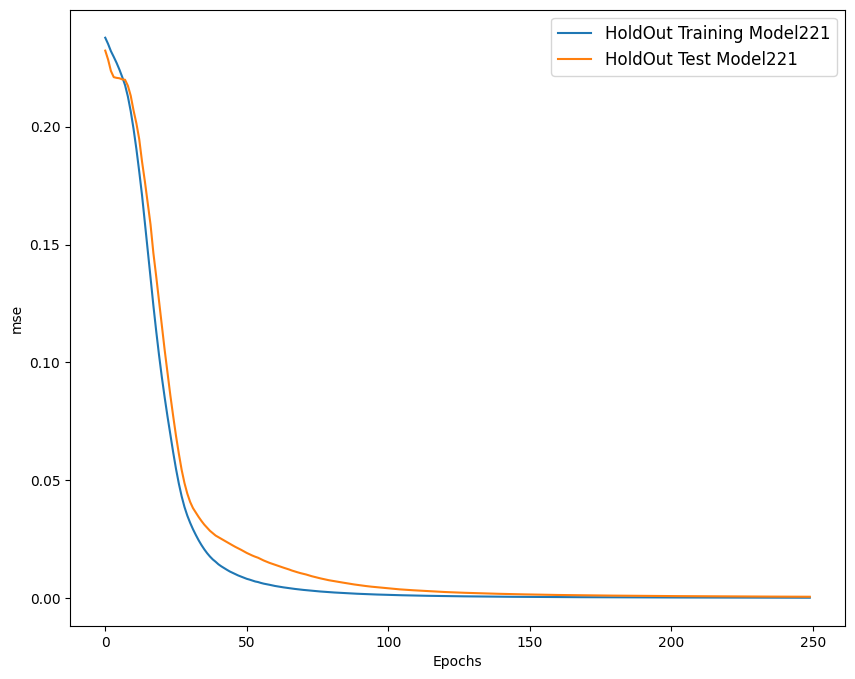

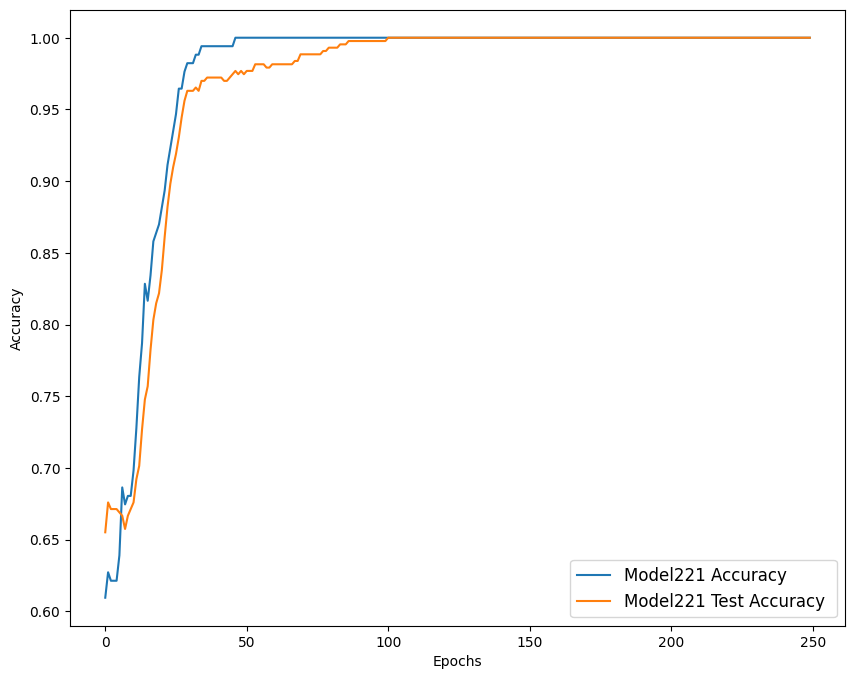

In [253]:
import matplotlib.pyplot as plt
def plot_history2(name, lines: dict, fig_size=(10, 6), label='mse'):
    plt.figure(figsize=fig_size)
    for elem in lines:
        plt.plot(lines[elem], label=elem)
    plt.legend(fontsize='12')
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.savefig(name+'.eps', format='eps')
    plt.savefig(name+'.png', format='png')

# plot_history2(name='Monk1_train', lines={result_row["Name"]: result_row['History']}, fig_size=(10,8))
plot_history2(name='Monk2_KFold', lines={'HoldOut Training '+result_row["Name"]: -np.sort(-np.array(result_row['Old_History'])), 'HoldOut Test '+result_row["Name"]: -np.sort(-np.array(result_row['Old_History_val']))}, fig_size=(10,8))
plot_history2(name='Monk2_Accuracy', lines={result_row["Name"]+" Accuracy ": result_row['Accuracy_History'], result_row["Name"]+" Test Accuracy ": result_row['Val_Accuracy_History']}, fig_size=(10,8), label='Accuracy')

{'regularization': 1e-07, 'learning_rate': 0.7, 'loss_function': 'mse', 'activation_functions': ['tanh'], 'output_activation': 'sigmoid', 'num_of_units': [4], 'num_layers': 1, 'momentum': 0.9, 'optimizer': 'sgd', 'initializers': 'uniform', 'nesterov': True, 'input_shape': [169, 17], 'callbacks': ['earlystopping_1e-4_20_False'], 'verbose': False, 'outputs': 1, 'model_name': 'Model221'}